In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [2]:
# 实现一个残差块:
class Residual(nn.Module):
    def __init__(self, in_channels, out_channels, use_1x1Conv2d=False, strides=1) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=strides, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)

        if use_1x1Conv2d:
            self.conv3 = nn.Conv2d(in_channels, out_channels, 1, stride=strides, padding=0) 
            # 注意1*1的卷积层padding=1, 这样k-2p = 1才不改变形状
            # 这个1*1的卷积层必须要和我们大的卷积层形状一样， 因为我们后面还需要在通道维上进行concat.
            # so, this 1*1 Conv2d is that shape map in_channels to out_channels
        else:
            self.conv3 = None
        
        # 剩下的几层:

        self.bn1 = nn.BatchNorm2d(num_features=out_channels) # 只要给出输出的数字即可.
        self.bn2 = nn.BatchNorm2d(out_channels)
    
    def forward(self, X):
        # 先经过线性层, 将输出拉到一个合适的范围, 然后再使用relu非激活函数进行非激活.
        Y = F.relu(self.bn1(self.conv1(X))) # 
        Y = self.bn2(self.conv2(Y))


        if self.conv3:
            X = self.conv3(X)
        
        # 然后做元素加法: 
        Y += X # 我们提到过, 这是一种剩内存的方法:
    
        return F.relu(Y) # 最后一个输出函数. 



In [3]:
# 测试一下: 
blk = Residual(3, 3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape # 可以看到, 可见, 高宽没有减半
# 因为我们设置的是in_channels=out_channels. 并且没有设置srides, 默认为1. 

torch.Size([4, 3, 6, 6])

In [4]:
# 如果我们想使通道数翻倍, 高宽减半, 这是stage或者block常见的设计思路:
# 那么我们就要使用1*1Conv2d来使输入和输出形状相匹配. 
blk = Residual(3, 6, use_1x1Conv2d=True ,strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

In [5]:
# 实现ResNet模型:
b1 = nn.Sequential( # 第一个stage类似于googleNet
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1), # 不改变高宽
)

In [6]:
# resnet_block, 上述是一个resnet_bolck. 这次我们要组成一个更大的stage其中使用resnet_block构成

def resnet_block(input_channels, out_chnanels, num_residuals, first_block=False):
    blk = [] # container

    # 
    for i in range(num_residuals): # 一个stage有多少个residual block
        if i == 0 and not first_block: # 如果是stage第一个, 但是不是第一个stage, 那么, 就高宽减半. 
            blk.append(Residual(input_channels, out_chnanels, use_1x1Conv2d=True, strides=2))
        else: # 不进行高宽减半了. 并且通道数也不改变
            blk.append(Residual(out_chnanels, out_chnanels)) # 
    
    return blk

In [7]:
# 构造ResNet:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True)) # *解包
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [8]:
# 构造最后的网络: 
# 最后与GoogLeNet一样, 最后使用全局汇聚(pooling)层,  然后使用全连接.
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1, 1)), # 形状: [batch, channel, 1, 1]
                    nn.Flatten(), 
                    nn.Linear(512, 10) # channel -> classes.
                )


In [9]:
# 看一下形状变化: 
X = torch.randn(size=(1                      , 1, 224, 224))
for layer in net:
    X = layer(X)
    print(f"{layer.__class__.__name__:10.10}\t: {X.shape}")

Sequential	: torch.Size([1, 64, 56, 56])
Sequential	: torch.Size([1, 64, 56, 56])
Sequential	: torch.Size([1, 128, 28, 28])
Sequential	: torch.Size([1, 256, 14, 14])
Sequential	: torch.Size([1, 512, 7, 7])
AdaptiveAv	: torch.Size([1, 512, 1, 1])
Flatten   	: torch.Size([1, 512])
Linear    	: torch.Size([1, 10])


loss 0.027, train acc 0.993, test acc 0.913
6547.3 examples/sec on cuda:0


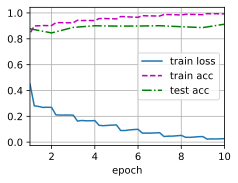

In [10]:
# 训练: 
num_epochs, lr, batch_size = 10, 1e-2, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96) # simple
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [11]:
class EMA():
    def __init__(self, model, decay):
        self.model = model
        self.decay = decay
        self.shadow = {}
        self.backup = {}

    def register(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def update(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                new_average = (1.0 - self.decay) * param.data + self.decay * self.shadow[name]
                self.shadow[name] = new_average.clone()

    def apply_shadow(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                self.backup[name] = param.data
                param.data = self.shadow[name]

    def restore(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.backup
                param.data = self.backup[name]
        self.backup = {}



# 初始化
ema = EMA(net, 0.999)
ema.register()


In [12]:
# eval前，apply shadow weights；eval之后，恢复原来模型的参数
def evaluate():
    ema.apply_shadow()
    # evaluate
    
    
    
    
    ema.restore()

def evaluate_accuracy_gpu(net, data_iter, device=None):
    """Compute the accuracy for a model on a dataset using a GPU.

    Defined in :numref:`sec_lenet`"""
    if isinstance(net, nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)
    ema.apply_shadow()
    

    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # Required for BERT Fine-tuning (to be covered later)
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), d2l.size(y))
    ema.restore()
    
    return metric[0] / metric[1]


def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """Train a model with a GPU (defined in Chapter 6).

    Defined in :numref:`sec_lenet`"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    
    net.apply(init_weights) # apply
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            ema.update()
            
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

# 训练过程中，更新完参数后，同步update shadow weights
# def train():
    
    
    
    
    
    
#     optimizer.step()
#     ema.update()



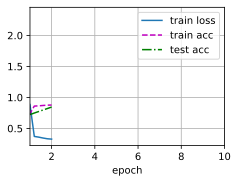

In [15]:
num_epochs, lr, batch_size = 10, 0.3, 256

train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, 96)
train_ch6(net, train_iter, test_iter, num_epochs, lr, device=d2l.try_gpu())


In [14]:
import os

!kill -9 os.getpid()

/bin/bash: -c: 行 1: 未预期的记号 "(" 附近有语法错误
/bin/bash: -c: 行 1: `kill -9 os.getpid()'
